In [1]:
import matplotlib.pyplot as plt
import trimesh # for reading mesh only
import pdb
import numpy as np
NORM = np.linalg.norm

In [2]:
def show(img,pts=None, pts2=None, pts3=None,msize=10, show=True,color=None):
    # visualization tool
    imgcp = img.copy()
    if  len(img.shape) == 1 or (len(img.shape)>1 and img.shape[1] == 2):
        img = img.reshape(-1,2)
        plt.plot(img[:,0],img[:,1],'k.')
        if pts is not None:
            pts = pts.reshape(-1,2)
            plt.plot(pts[:,0],pts[:,1],'c.')
        if pts2 is not None:
            pts2 = pts2.reshape(-1,2)
            plt.plot(pts2[:,0],pts2[:,1],'r.')
        if pts3 is not None:
            pts3 = pts3.reshape(-1,2)
            plt.plot(pts3[:,0],pts3[:,1],'m.')
        plt.show()
    elif img.shape[1] > 2:
        if len(img.shape) > 2:
            if color is None:
                color = (255, 0, 0)
            color2 = (0, 255, 0)
            color3 = (125,52,133)
        else:
            color = 50
            color2 = 125
            color3 = 200
        if pts is not None:
            pts = pts.astype(int)
            pts = pts.reshape(-1,2)
            for pt in pts:
                cv2.circle(imgcp, (pt[0], pt[1]), 0, color, msize)
            if pts2 is not None:
                pts2 = pts2.astype(int)
                pts2 = pts2.reshape(-1,2)
                for pt in pts2:
                    cv2.circle(imgcp, (pt[0], pt[1]), msize, color2, msize//2)
                if pts3 is not None:
                    pts3 = pts3.astype(int)
                    pts3 = pts3.reshape(-1,2)
                    for pt in pts3:
                        cv2.circle(imgcp, (pt[0], pt[1]), 0, color3, msize)
        
        if show:
            plt.imshow(imgcp),plt.show()
            return imgcp


In [3]:
def get_neibour(id,f):
    neibour_list = []
    for i in id:
        neibour = set(f[np.where(f==i)[0]].flatten())
        neibour.remove(i)
        neibour = list(neibour)
        neibour_list.extend(neibour)
    return neibour_list

def get_adj(v,f,level):
    adj = []
    for i,vt in enumerate(v):
        neibour_list = [i]
        for j in range(level):
            neibour_list.extend( get_neibour(neibour_list,f) )
        neibour_list.remove(i)
        adj.append(neibour_list)
    return adj

def get_edges(v,f):
    edges = []
    adj = []
    for i,vt in enumerate(v):
        neibour = get_neibour([i],f)
        adj.append(neibour)
        edges.append( np.sort(np.vstack(( np.repeat(i,len(neibour)),neibour)).T,axis=1) )
    return edges,adj

def find_clockwise_nearest(vector_a,vector_b_arr,id_list):

    """
    This function find the smallest clockwise angle between vector_a and vector in vector_b_arr
    Args:
    1.  vector_a
    2.  vector_b_arr , array of vectors
    3.  id_list: id of verts in vert_b_arr
    Return:
    1 . find the vector b in vector b array that has the smallest angle between vector a 
    and return the id of the point that consist vector b
    """
    ang = np.arctan2(vector_a[0]*vector_b_arr[:,1]-vector_a[1]*vector_b_arr[:,0],vector_a[0]*vector_b_arr[:,0]+vector_a[1]*vector_b_arr[:,1])
    # id_list = vector_b_arr[:,2]
    positive_id = np.where(ang > 1e-12)[0] # when ang == 0, means vector_a find it self.  using 1e-12 to aviod float precision error,
    if positive_id.shape[0] > 0 : 
        # e.g angle [-20,20,30] we wanna get 20 degree, rather than -20 degree, 
        # because -20 degree means the vector has neg direction compare to vector_a
        clockwise_nearest = positive_id[np.argmin(ang[positive_id])]
    else:
        negative_id = np.where(ang < 0)[0]
        clockwise_nearest = negative_id[np.argmin(ang[negative_id])]
    next_pt_id = int(id_list[clockwise_nearest])
    return next_pt_id

def find_inters(pv,rv,qv,sv):
    # find intersections https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect
    # p is one vector
    # q is a set of vectors
    cross = rv[0]*sv[:,1]-rv[1]*sv[:,0]
    cross [cross == 0] = 1
    if np.any(cross==0):
        pdb.set_trace()
    qv_minus_pv = qv - pv
    t = (qv_minus_pv[:,0]*sv[:,1]-qv_minus_pv[:,1]*sv[:,0]) / cross
    u = (qv_minus_pv[:,0]*rv[1]-qv_minus_pv[:,1]*rv[0]) / cross
    line_has_inters = np.where( ( (t < 1-1e-6) & (t>1e-6))  & ( (u<1-1e-6) & (u>1e-6)) & (cross !=0) )[0]
    if line_has_inters.shape[0] !=0:
        intersections = pv + t[line_has_inters].reshape(-1,1) * rv
        return intersections,line_has_inters
    else:
        return None,None

def tracing_outline_robust(verts,faces):
    """
    this is the version not require tree building, it calculates all intersections from all edges
    args:
    1.N X 2 verts
    2.M X 3 faces
    Return:
    outline points coordinates
    """
    start_id = np.argmin(verts[:,0])
    center_pt = verts[start_id]
    pre_pt = center_pt.copy()
    pre_pt[0] = pre_pt[0] - 1 #start from left
    next_id = start_id
    break_c = verts.shape[0] 
    i = 0
    edges_list,adj = get_edges(verts,faces)
    edge_arr = np.vstack((np.asarray(edges_list)))
    out_points = []
    connect_id = []
    out_id = []
    out_id.append(next_id)
    while True and i < break_c:
        i += 1
        if len(connect_id) == 0:
            connect_id = adj[next_id]
        vector_a = pre_pt - center_pt
        vector_b_arr = verts[connect_id] - center_pt
        next_id = find_clockwise_nearest(vector_a,vector_b_arr,connect_id)
        if next_id == start_id:
            break
        pre_pt = center_pt
        center_pt = verts[next_id]
        arr_q = verts[edge_arr[:,0]]
        arr_r = verts[edge_arr[:,1]] - arr_q
        inters,inter_edge_id = find_inters(center_pt,pre_pt-center_pt,arr_q,arr_r)
        if inters is not None:
            nearest = np.argmin(NORM(inters - pre_pt,axis=1))
            center_pt = inters[nearest]
            connect_id = np.ndarray.tolist(edge_arr[inter_edge_id[nearest]])
            connect_id.append(next_id)
            inters = None  
        else:
            connect_id = []     
            inters = None
            out_id.append(next_id)      
        out_points.append(center_pt)    
    return np.asarray(out_points),out_id

In [4]:
mesh_path = '/home/tingting/Desktop/netvirta/fullbody/fullbody.sg/demo.ply'
mesh = trimesh.load_mesh( mesh_path, process=False)
v,f = mesh.vertices,mesh.faces
v_2d = v[:,:2]
points,ids = tracing_outline_robust(v_2d,f) # not doing any projection,just simply take the verts's x and y .

/home/tingting/Desktop/netvirta/fullbody/fullbody.sg/env/lib/python3.7/site-packages/trimesh/exchange/ply.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in lines])
/home/tingting/Desktop/netvirta/fullbody/fullbody.sg/env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


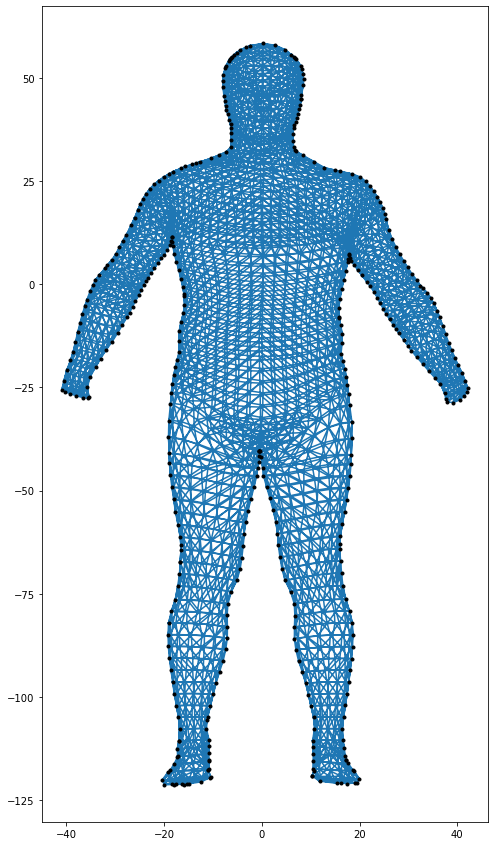

In [5]:
# visualizing points tracing offline
fig= plt.figure(figsize=(8,15))
plt.triplot(v_2d[:, 0], v_2d[:, 1], f)
show(points)

In [ ]:
""" # delete this line to visualize points tracing dynamic


%matplotlib # plot with windows
fig= plt.figure(figsize=(8,15))
plt.triplot(v_2d[:, 0], v_2d[:, 1], f)
plt.show()
chuck = len(points)//20
if len(points)%20!=0:
    chuck += 1
for i in range(chuck):
    sub_p = points[i*20:(i+1)*20]
    plt.plot(sub_p[:,0],sub_p[:,1],'r*')
    plt.pause(0.05)
    plt.show()